# Kinetic free Hartree-Fock energies with Multiwavelets using VAMPyR


We begin with by introducing the power method scheme for the Hartree-Fock equations

\begin{align*}
\tilde{\Phi}^{n+1} = \vec{\mathbf{H}}^{\mathbf{\mu}_n}\left[ \left(\mathbf{V}_{nuc}  + \mathbf{J}^n -  \mathbf{K}^n \right) \mathbf{\Phi}^n\right]
\end{align*}

where the tilde on the orbital vector $\tilde{\Phi}^{n+1}$, denotes the output orbitals are not ortonormal, as the Helmholtz Operator does not conserve the norm when the eigenvalues are not exact [1]. The nuclear potential $\mathbf{V}_{nuc}$ is defined as 

\begin{align*}
\mathbf{V}_{nuc} = \sum_i \frac{1}{||R_i - r||}
\end{align*}

and element in $\mathbf{J}^n\mathbf{\Phi}^n$ and $\mathbf{K}^n\mathbf{\Phi}^n$ are defined as

\begin{align*}
J^{n} \phi^n_i &= \sum_i^{N/2} 2 \hat{P}[ {\phi_j^{n}}^2] \phi_i^{n} \\
K^{n} \phi^n_i &= \sum_i^{N/2}  \hat{P}[\phi_i^n \phi_j^{n}]\phi_j^{n}
\end{align*}


In this implementation we diagolanlize the Fock Matrix, $F^n$ is updated as

\begin{align*}
\mathbf{F}^{n+1} = \mathbf{F}^n + \Delta S^n_1 \mathbf{F}^n + \Delta S^n_2 \mathbf{F}^n + \Delta \mathbf{F}_{pot}^{n}
\end{align*}

where

\begin{align*}
\Delta S^n_1 &= \langle\Delta\mathbf{\Phi}^n |  \mathbf{\Phi}^n \rangle \\
\Delta S^n_2 &= \langle\tilde{\mathbf{\Phi}}^{n+1} | \Delta \tilde{\mathbf{\Phi}}^n \rangle
\end{align*}

and 

\begin{align*}
\Delta \mathbf{F}_{pot}^{n} = \langle \tilde{\mathbf{\Phi}}^{n+1}|\mathbf{V}^n | \Delta \tilde{\mathbf{\Phi}}^n\rangle + \langle \tilde{\mathbf{\Phi}}^{n+1}|\Delta \mathbf{V}^n | \tilde{\mathbf{\Phi}}^{n+1}\rangle
\end{align*}


We calculate the orbitalenergies $\epsilon_i$ are the eigen-values of the Fock matrix, and the total
energy and it's component are calcuated as

The energy contributions are calculated as follows

\begin{align*}
E_{tot} &= 2\sum_i^{N/2} \epsilon_i - tr( \langle \mathbf{\Phi}| \mathbf{J} | \mathbf{\Phi} \rangle) + tr( \langle \mathbf{\Phi} | \mathbf{K} | \mathbf{\Phi}\rangle)\\
E_{coul} &= tr( \langle \mathbf{\Phi} | \mathbf{J} | \mathbf{\Phi} \rangle) \\
E_{ex} &= -tr(\langle \mathbf{\Phi} | \mathbf{K} | \mathbf{\Phi} \rangle) \\
E_{en} &= 2tr(\langle \mathbf{\Phi} | \mathbf{V}_{nuc} | \mathbf{\Phi} \rangle) \\
E_{kin} &= E_{tot} - E_{coul} - E_{ex} - E_{en}
\end{align*}

where the orbital energies $\epsilon_i$ are the eigenvalues of the Fock matrix $F^n$.

Here we have implemented a simple  SCF for kinetic free HF using VAMPyR, a Multiresolution Analysis Python library. Next we'll run the SCF for Be, and we'll show how the orbitals and energies converge. We'll do this in x steps.

1. Set nuclear charge and position
2. Create a Multiresolution Analysis and set precison
2. Create starting guesses for the Fock matrix $F^n$ and orbitals $\Phi_n$
3. Run the SCF
4. Plot energy and orbital errors for each SCF cycle
5. Plot converged orbitals

In [2]:
from vampyr import vampyr3d as vp
from scf_solver import scf_solver
from starting_guess import starting_guess

import numpy as np
import pandas as pd

# Define Be
be = [[4, [0.0, 0.0, 0.0]]]

# Define Multiresoltion analysis and set precision
mra = vp.MultiResolutionAnalysis(order=7, box=[-16, 16])
precision = 1.0e-4

# Starting guesses for the fock matrix and orbitals

Phi_n = starting_guess(mra, precision, nr_of_orbitals=2, center=[0.0,0.0,0.0])
fock_n = np.array([[-1.0, 0.0], [0.0, -0.5]]) 

In [3]:
# This can take a while especailly on slow computers and high precision
orbital_updates, energies, Phi_n = scf_solver(Phi_n, fock_n, be, mra, precision)

[[-1.   0. ]
 [ 0.  -0.5]]
[[-3.70577872  0.        ]
 [ 0.         -0.14052104]]
[[-4.59455902  0.        ]
 [ 0.         -0.30882647]]
[[-4.74665276  0.        ]
 [ 0.         -0.30911719]]
[[-4.75432944  0.        ]
 [ 0.         -0.30889382]]
[[-4.74343648  0.        ]
 [ 0.         -0.30898504]]
[[-4.73698014  0.        ]
 [ 0.         -0.30911459]]
[[-4.73429694  0.        ]
 [ 0.         -0.30919827]]
[[-4.73328538  0.        ]
 [ 0.         -0.30924172]]


To study the convergence we'll use pandas, an easy to use data analysys tool. We'll first
look at how the energy converges

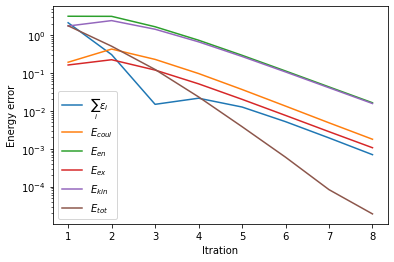

In [11]:
energies_df = pd.DataFrame(energies)
# calcuate differences between each row
energy_diff = energies_df.diff(axis=0)
energy_diff = energy_diff.dropna()
energy_diff = energy_diff.abs()

import matplotlib.pyplot as plt
energy_diff.plot(logy=True)
plt.xlabel("Itration")
plt.ylabel("Energy error")
plt.show()


<AxesSubplot:>

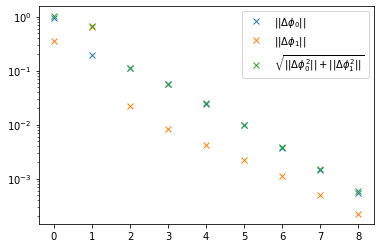

In [24]:
updates_df = pd.DataFrame(orbital_updates)
updates_df = updates_df.set_axis(["$||\Delta \phi_0||$", "$||\Delta \phi_1$||"], axis=1)
updates_df["$\sqrt{||\Delta \phi_0^2|| + ||\Delta \phi_1^2||}$"] = updates_df.apply(lambda x : np.sqrt(x[0]**2 + x[1]**2), axis=1)
updates_df.plot(logy=True, style="x")


Then let's plot the orbitals along the z-axis

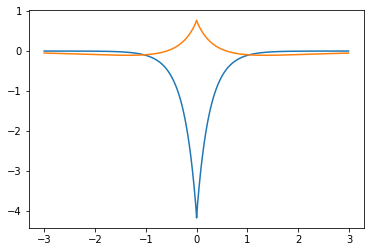

In [25]:
x = np.arange(-3.0, 3.0, 0.01)
phi_0 = [Phi_n[0]([0.0, 0.0, z]) for z in x]
phi_1 = [Phi_n[1]([0.0, 0.0, z]) for z in x]
plt.plot(x, phi_0)
plt.plot(x, phi_1)

# Bibliography
[1] Kalos M.H. Monte carlo calculations of the ground state of three- and four- body nuclei. Phys. Rev., 128(4):1791, 1962 